# Insight Data Challenge 

Apparently, I'm supposed to build a model to predict whether cells are benign or cancerous based on clump thickness, uniformity of cell size, uniformity of cell shape, marginal adhesion, single epithelial cell size, bare nuclei, bland chromatin, normal nucleoli, and mitoses. I don't know what most of those words mean, but oh, well. Let's import some useful packages.

In [1]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np

Let's also import the data into a dataframe:

In [2]:
df = pd.read_table('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data', sep=',', names=['id', 'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class'])

## Preprocessing 

This is what the dataframe originally looks like:

In [3]:
df[:10]

,id,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
5,1017122,8,10,10,8,7,10,9,7,1,4
6,1018099,1,1,1,1,2,10,3,1,1,2
7,1018561,2,1,2,1,2,1,3,1,1,2
8,1033078,2,1,1,1,2,1,1,1,5,2
9,1033078,4,2,1,1,2,1,2,1,1,2


The class takes two values: 2 for benign and 4 for malignant. For the sake of a classifier, it will be better to have these as 0's and 1's. A simple transformation accomplishes that:

In [4]:
df['Class'] = (df['Class']/2 -1).astype(int)

In [5]:
df[:10]

,id,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0
5,1017122,8,10,10,8,7,10,9,7,1,1
6,1018099,1,1,1,1,2,10,3,1,1,0
7,1018561,2,1,2,1,2,1,3,1,1,0
8,1033078,2,1,1,1,2,1,1,1,5,0
9,1033078,4,2,1,1,2,1,2,1,1,0


So now we have zeros for benign and ones for malignant. The is also a problem with the `'Bare Nuclei'` column: some of the values are question marks, and because of that, pandas interpreted the data type for that column to be a string. We need to (1) replace the missing values and (2) change the type to int, so that functions and methods we use in the future will treat those values as numbers.

To accomplish (1), I'm just going to replace each question mark with the mode of the column. There are smarter ways to do this; for example, I could look into how the number of bare nuclei correlate with the other features, and decide the most likely values for bare nuclei based on that. However, there are only 16 missing values out of almost 700 samples, so doing something smart is unlikely to change my results much. So let's get the mode of the  `'Bare Nuclei'` column.

In [6]:
from scipy.stats import mode

In [7]:
mode(df['Bare Nuclei'])

/home/eric/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:250: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


ModeResult(mode=array(['1'], dtype=object), count=array([402]))

The mode is one, so I'm going to use the `replace` method in pandas to get rid of the question marks and replace them with 1's. I'm inputing the 1's as a string, to be consistent with the rest of the column. After that, I change the type to `int`.

In [8]:
df['Bare Nuclei'] = df['Bare Nuclei'].replace(to_replace='?', value = '1')
df['Bare Nuclei'] = df['Bare Nuclei'].astype(int)

## Data Exploration 

At this point, we can start exploring the data. To do this, I'm going to histogram malignant and benign tumors by the values of the nine features we have. In doing so, I will use a function, `prepForHist`, that I originally wrote for my Insight project. The function `prepForHist` takes the values of the feature and the corresponding classes as input, and outputs two lists of values: one corresponding to malignant cells, and the other corresponding to benign cells. The two output lists can be used as input to `matplotlib`'s `hist` function.

In [9]:
def prepForHist(vals, bools):
    """Given a list of values (vals) corresponding to a feature, and a list of booleans (bools) indicating class, 
    returns one list of values that corresponds to True (valsTrue), and another that corresponds to false (valsFalse).
    valsTrue and valsFalse can be used as input to plt.hist() to make a histogram of values for which completeness is
    true or false."""
    valsFalse = []
    valsTrue = []
    for i in range(len(bools)):
        if bools[i]:
            valsTrue.append(vals[i])
        else:
            valsFalse.append(vals[i])
    return valsTrue, valsFalse

Now, we can easily histogram benign and malignant tumors:

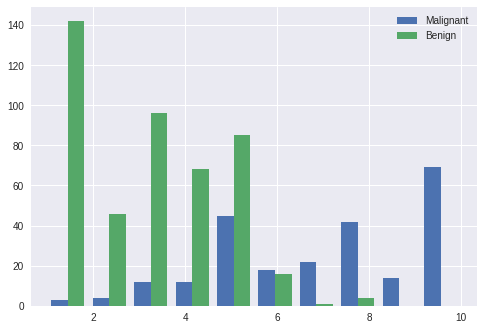

In [10]:
plt.hist(prepForHist(df['Clump Thickness'].values, df['Class'].values))
plt.legend(['Malignant', 'Benign'])
plt.show()

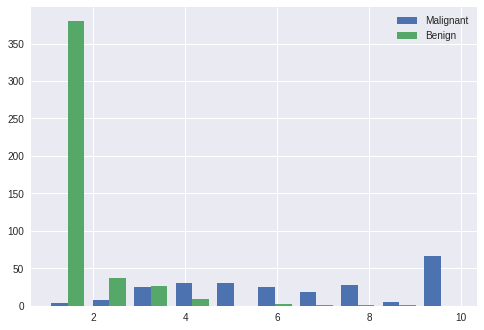

In [11]:
plt.hist(prepForHist(df['Uniformity of Cell Size'].values, df['Class'].values))
plt.legend(['Malignant', 'Benign'])
plt.show()

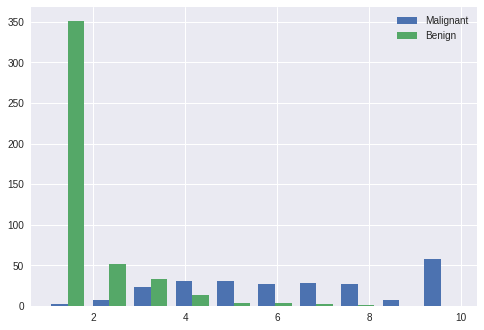

In [12]:
plt.hist(prepForHist(df['Uniformity of Cell Shape'].values, df['Class'].values))
plt.legend(['Malignant', 'Benign'])
plt.show()

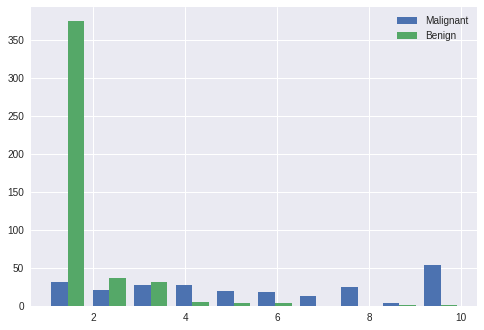

In [13]:
plt.hist(prepForHist(df['Marginal Adhesion'].values, df['Class'].values))
plt.legend(['Malignant', 'Benign'])
plt.show()

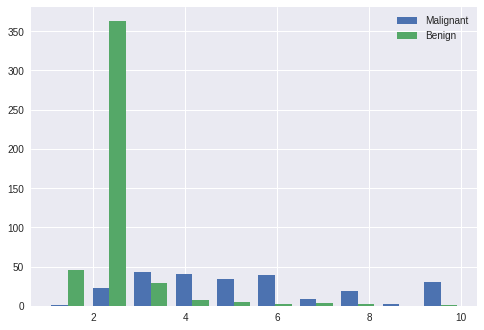

In [14]:
plt.hist(prepForHist(df['Single Epithelial Cell Size'].values, df['Class'].values))
plt.legend(['Malignant', 'Benign'])
plt.show()

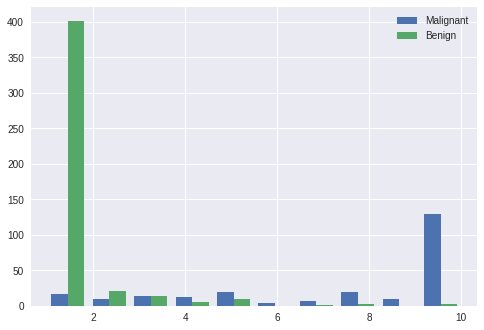

In [15]:
plt.hist(prepForHist(df['Bare Nuclei'].values, df['Class'].values))
plt.legend(['Malignant', 'Benign'])
plt.show()

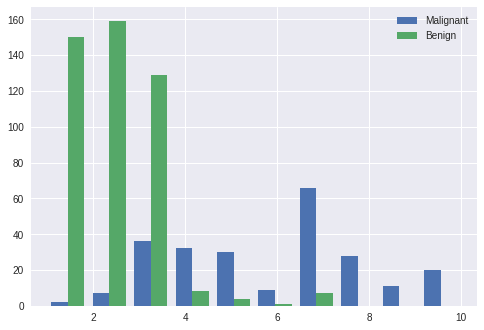

In [16]:
plt.hist(prepForHist(df['Bland Chromatin'].values, df['Class'].values))
plt.legend(['Malignant', 'Benign'])
plt.show()

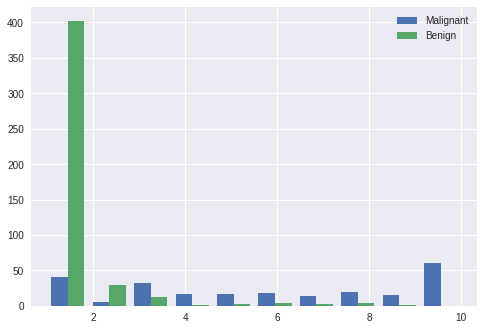

In [17]:
plt.hist(prepForHist(df['Normal Nucleoli'].values, df['Class'].values))
plt.legend(['Malignant', 'Benign'])
plt.show()

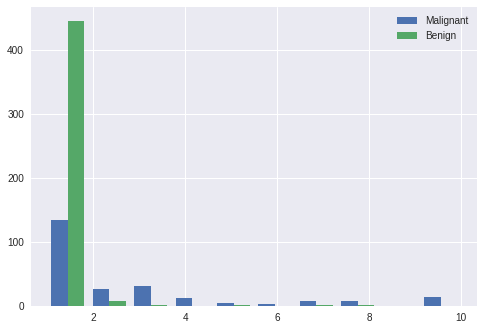

In [18]:
plt.hist(prepForHist(df['Mitoses'].values, df['Class'].values))
plt.legend(['Malignant', 'Benign'])
plt.show()

Happily, it seems that, for all features, the probability of malignancy increases monotonically with increasing feature value. This monotonic behavior indicates that logistic regression can perform well here. Let's try it.

## Logistic Regression 

In [19]:
features = ['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape','Marginal Adhesion','Single Epithelial Cell Size','Bare Nuclei','Bland Chromatin','Normal Nucleoli','Mitoses']

In [20]:
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression as logreg

First, we'll split our data up into training and testing sets:

In [21]:
dftrain, dftest = tts(df, test_size=.2)

We'll define a logistic regression model without regularization (`C=float('inf')`) because we have far more samples than features, and logistic regression does not suffer from high variance. We will also use the L-BFGS solver, since the default takes forever to fit the data.

In [22]:
model = logreg(C=float('inf'), solver='lbfgs')

In [23]:
model.fit(dftrain[features], dftrain['Class'])

LogisticRegression(C=inf, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

Now that we've fit the data, how accurate is it?

In [24]:
model.score(dftest[features], dftest['Class'])

0.9642857142857143

96% accuracy...sounds nice. How does that compare to random chance?

In [25]:
1.0-np.mean(dftest['Class'])

0.7357142857142858

It's much better than random chance. Nice! What about precision and recall?

In [26]:
from sklearn.metrics import precision_recall_fscore_support as prfs

In [27]:
prfs(dftest['Class'], model.predict(dftest[features]))

(array([ 0.99,  0.9 ]),
 array([ 0.96116505,  0.97297297]),
 array([ 0.97536946,  0.93506494]),
 array([103,  37]))

Those numbers look pretty good! In particular, I'm interested in the recall of the malignant tumors, which is 97%. The reason I'm concerned about this number is that we want it to be as high as possible--we don't want anyone with cancer to go undiscovered, since that would greatly increase the chance of them dying. Precision isn't as important here, because the worst thing that can happen with false negatives is that the person gets further tests and finds out they don't have cancer.

To get a sense for how high we can get the recall, let's look at the ROC curve.

In [28]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [29]:
fpr, tpr, thresholds = roc_curve(dftest['Class'], model.predict_proba(dftest[features])[:,1], drop_intermediate=False)

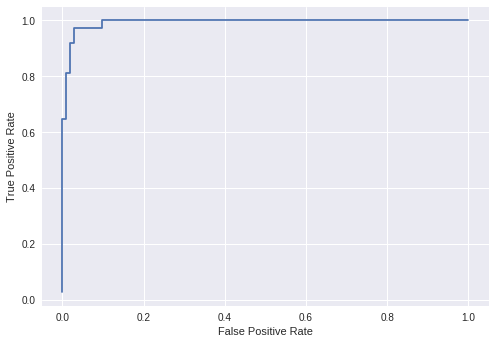

In [30]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Area Under Curve = .92')
plt.show()

In [31]:
roc_auc_score(dftest['Class'], model.predict_proba(dftest[features])[:,1])

0.99212805038047758

...That looks pretty nice, actually, with an area under the curve of .99. What threshold do we need to set to get a recall (or true positive rate) of 100%?

In [32]:
for i in range(len(tpr)):
    if tpr[i] == 1.:
        print i
        break

46


In [33]:
thresholds[46]

0.12200321110011296

12%, apperently. What is the resulting false positive rate?

In [34]:
fpr[60]

0.25242718446601942

So we can get 100% recall (on our test set, anyway) with a 25% false positive rate. Can we do better?

I noticed that many of the histograms above are very similar, suggesting that many of the features are highly correlated. Having multiple of these highly correlated features doesn't add much information to the model. What happens if we do PCA on the features, so that we can give the model features that aren't (linearly) correlated? Will that make it better? 

## Principal Component Analysis 

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Before we do PCA, we need to normalize our features.

In [36]:
scaler = StandardScaler()

In [37]:
scaler.fit(dftrain[features])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [38]:
dftrainscaled = scaler.transform(dftrain[features])
dftestscaled = scaler.transform(dftest[features])

In [39]:
pca = PCA(n_components=len(features))

In [40]:
pca.fit(dftrainscaled)

PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [41]:
dftrainpca = pca.transform(dftrainscaled)
dftestpca = pca.transform(dftestscaled)

Let's explore the principal components with histograms:

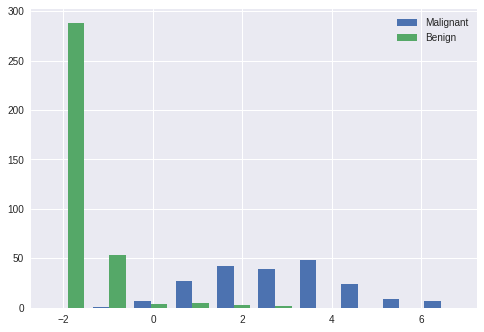

In [42]:
plt.hist(prepForHist(dftrainpca[:,0], dftrain['Class'].values))
plt.legend(['Malignant', 'Benign'])
plt.show()

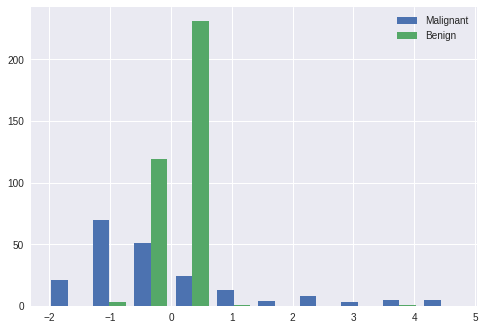

In [43]:
plt.hist(prepForHist(dftrainpca[:,1], dftrain['Class'].values))
plt.legend(['Malignant', 'Benign'])
plt.show()

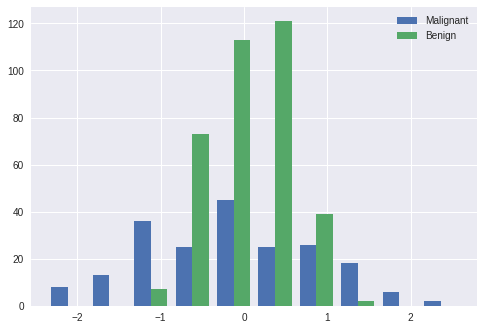

In [44]:
plt.hist(prepForHist(dftrainpca[:,2], dftrain['Class'].values))
plt.legend(['Malignant', 'Benign'])
plt.show()

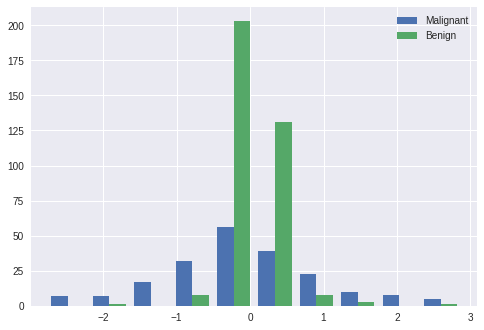

In [45]:
plt.hist(prepForHist(dftrainpca[:,3], dftrain['Class'].values))
plt.legend(['Malignant', 'Benign'])
plt.show()

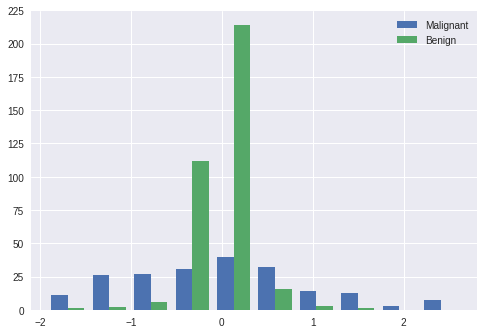

In [46]:
plt.hist(prepForHist(dftrainpca[:,4], dftrain['Class'].values))
plt.legend(['Malignant', 'Benign'])
plt.show()

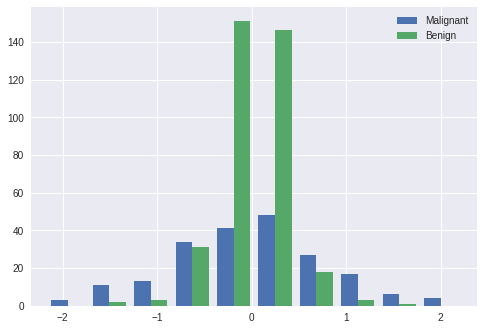

In [47]:
plt.hist(prepForHist(dftrainpca[:,5], dftrain['Class'].values))
plt.legend(['Malignant', 'Benign'])
plt.show()

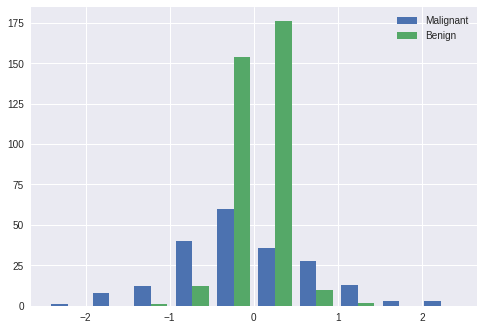

In [48]:
plt.hist(prepForHist(dftrainpca[:,6], dftrain['Class'].values))
plt.legend(['Malignant', 'Benign'])
plt.show()

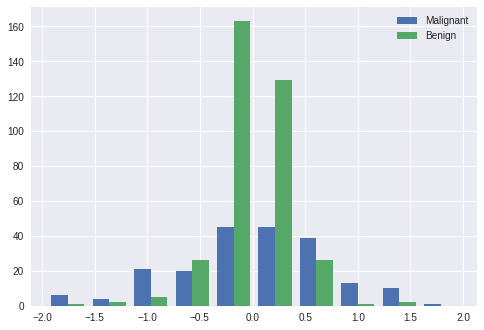

In [49]:
plt.hist(prepForHist(dftrainpca[:,7], dftrain['Class'].values))
plt.legend(['Malignant', 'Benign'])
plt.show()

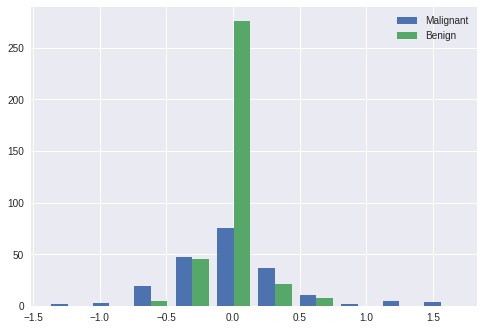

In [50]:
plt.hist(prepForHist(dftrainpca[:,8], dftrain['Class'].values))
plt.legend(['Malignant', 'Benign'])
plt.show()

It looks like the probability of malignancy increaces monotinically with the first principal component, but it increases monotinically with the *absolute values* of the other principal components. If we still want to use logistic regression, then, we need to use the first principal component as one feature, the the absolute values of the other principal components as the other features.

In [51]:
df_pca_features_train = pd.DataFrame()
df_pca_features_train['feature1'] = dftrainpca[:,0]
df_pca_features_train['feature2'] = np.absolute(dftrainpca[:,1])
df_pca_features_train['feature3'] = np.absolute(dftrainpca[:,2])
df_pca_features_train['feature4'] = np.absolute(dftrainpca[:,3])
df_pca_features_train['feature5'] = np.absolute(dftrainpca[:,4])
df_pca_features_train['feature6'] = np.absolute(dftrainpca[:,5])
df_pca_features_train['feature7'] = np.absolute(dftrainpca[:,6])
df_pca_features_train['feature8'] = np.absolute(dftrainpca[:,7])
df_pca_features_train['feature9'] = np.absolute(dftrainpca[:,8])
df_pca_features_train['Class'] = dftrain['Class'].astype(int)

In [52]:
df_pca_features_test = pd.DataFrame()
df_pca_features_test['feature1'] = dftestpca[:,0]
df_pca_features_test['feature2'] = np.absolute(dftestpca[:,1])
df_pca_features_test['feature3'] = np.absolute(dftestpca[:,2])
df_pca_features_test['feature4'] = np.absolute(dftestpca[:,3])
df_pca_features_test['feature5'] = np.absolute(dftestpca[:,4])
df_pca_features_test['feature6'] = np.absolute(dftestpca[:,5])
df_pca_features_test['feature7'] = np.absolute(dftestpca[:,6])
df_pca_features_test['feature8'] = np.absolute(dftestpca[:,7])
df_pca_features_test['feature9'] = np.absolute(dftestpca[:,8])
df_pca_features_test['Class'] = dftest['Class']

In [53]:
features2 = ['feature1','feature2','feature3','feature4','feature5','feature6','feature7','feature8','feature9']

## New Logistic Regression Model 

Now let's try logistic regression again:

In [54]:
model.fit(df_pca_features_train[features2], dftrain['Class'])

LogisticRegression(C=inf, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [55]:
model.score(df_pca_features_test[features2], dftest['Class'])

0.9642857142857143

The accuracy is still 96%.

In [56]:
prfs(dftest['Class'], model.predict(df_pca_features_test[features2]))

(array([ 0.99,  0.9 ]),
 array([ 0.96116505,  0.97297297]),
 array([ 0.97536946,  0.93506494]),
 array([103,  37]))

The recall remains the same.

In [57]:
fpr2, tpr2, thresholds2 = roc_curve(dftest['Class'], model.predict_proba(df_pca_features_test[features2])[:,1], drop_intermediate=False)

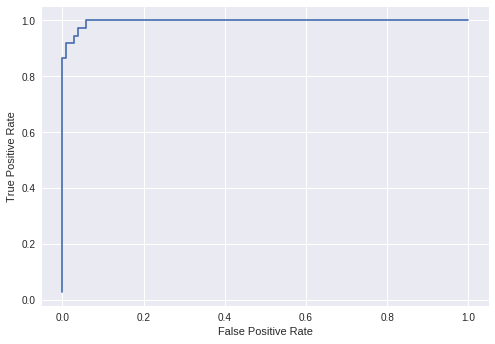

In [58]:
plt.plot(fpr2, tpr2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Area Under Curve = .92')
plt.show()

In [60]:
roc_auc_score(dftest['Class'], model.predict_proba(df_pca_features_test[features2])[:,1])

0.99606402519023873

The ROC AUC score is slightly better, though.

In [61]:
for i in range(len(tpr2)):
    if tpr2[i] == 1.:
        print i
        break

42


In [62]:
thresholds2[42]

0.10180329300721916

In [63]:
fpr2[42]

0.058252427184466021

...And now, **we can get 100% recall with just a 5.8% false positive rate!** I call this a success. :)